In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install face_recognition

import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=2c6d61b6c949b96f815d9813a1628d5eea439744f8d1f6f22395208a0a0a2393
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


### Mapping:

1.   Image pre-processing
2.   Train the model
3.   Evaluate and make prediction
4.   Add function to take photo
5.   Pre-process the unknown image and detect the face and features and label them based on training data

# Image Pre-Processing

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    face_encodings = []
    label_dict = {}
    label_idx = 0

    # Iterate over main folder and its subfolders
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            # Assign label index
            label_dict[label] = label_idx
            label_idx += 1

            # Iterate over images in the subfolder
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Load image and detect faces
                img = cv2.imread(img_path)
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                face_locations = face_recognition.face_locations(rgb_img)

                # Pre-processing and saving the images and encodings in lists
                if face_locations:
                    for (top, right, bottom, left) in face_locations:
                        face_img = rgb_img[top:bottom, left:right]
                        face_img = cv2.resize(face_img, (100, 100))  # Resize to a fixed size
                        face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

                        # Extract facial encoding
                        encoding = face_recognition.face_encodings(rgb_img, [(top, right, bottom, left)])[0]

                        images.append(face_img)
                        face_encodings.append(encoding)
                        labels.append(label_dict[label])

    return np.array(images), np.array(face_encodings), np.array(labels), label_dict


In [4]:
# Load and preprocess images
train_folder = '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/Emotion Data/Train'
test_folder = '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/Emotion Data/Test'
train_images, train_encodings, train_labels, train_label_dict = load_images_from_folder(train_folder)
test_images, test_encodings, test_labels, test_label_dict = load_images_from_folder(test_folder)

In [5]:
print('Training Images Shape:', train_images.shape)
print('Training Encodings Shape:', train_encodings.shape)

print('Testing Images Shape:', test_images.shape)
print('Training Encodings Shape:', test_encodings.shape)

print('Labels:', train_label_dict)

Training Images Shape: (533, 100, 100)
Training Encodings Shape: (533, 128)
Testing Images Shape: (86, 100, 100)
Training Encodings Shape: (86, 128)
Labels: {'Angry': 0, 'Neutral': 1, 'Happy': 2, 'Sad': 3, 'Surprised': 4}


# Train SVM Model

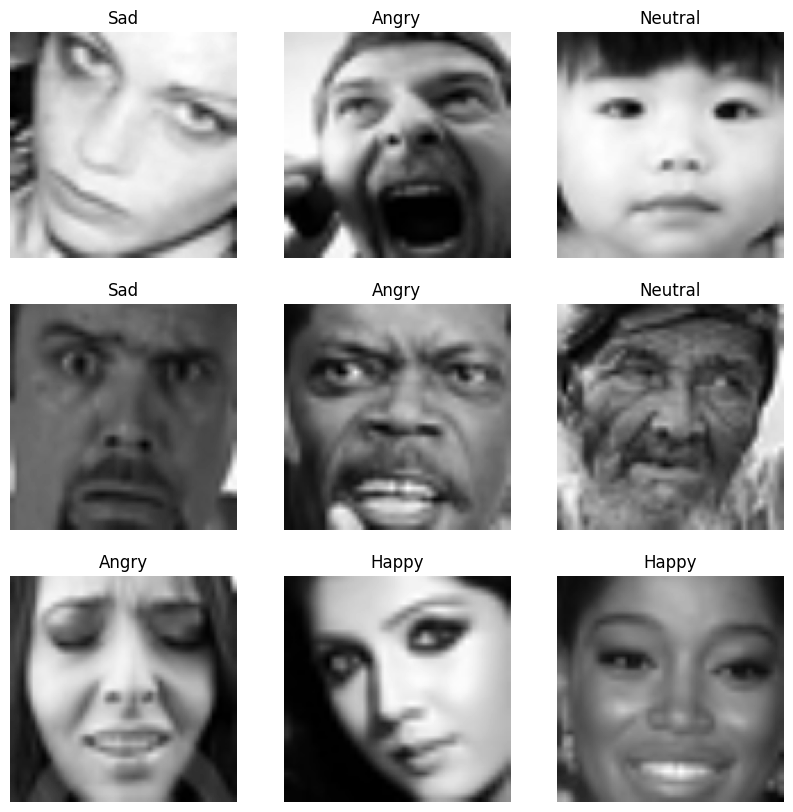

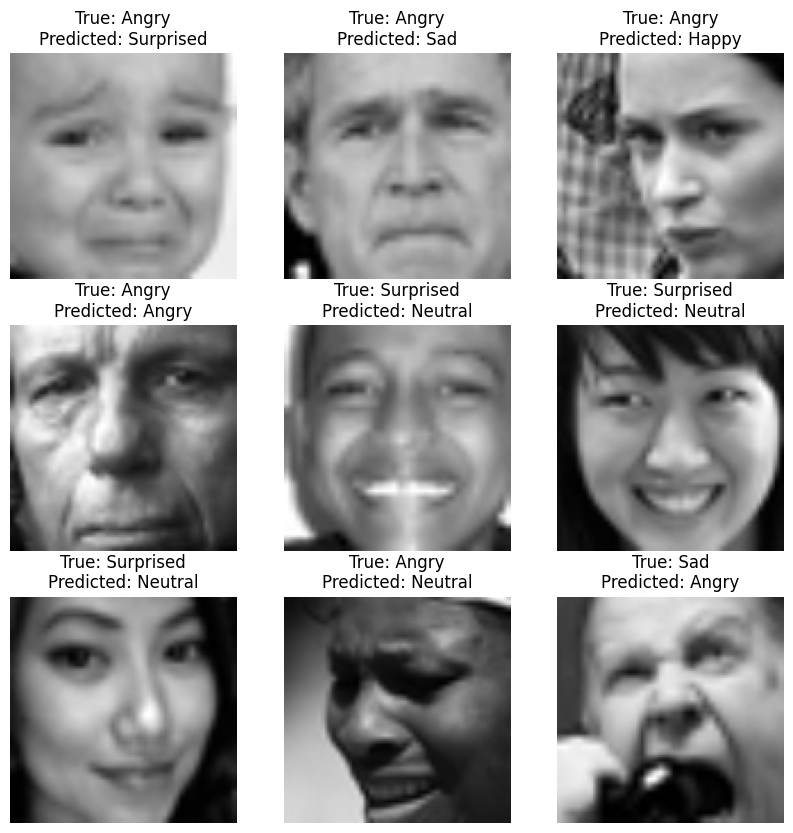

Accuracy: 0.2441860465116279
Classification Report:
              precision    recall  f1-score   support

       Angry       0.20      0.31      0.24        13
     Neutral       0.37      0.30      0.33        23
       Happy       0.33      0.32      0.32        19
         Sad       0.00      0.00      0.00        10
   Surprised       0.15      0.19      0.17        21

    accuracy                           0.24        86
   macro avg       0.21      0.22      0.21        86
weighted avg       0.24      0.24      0.24        86



In [9]:
from sklearn.svm import SVC


shuffle_indices = np.arange(len(train_images))
np.random.shuffle(shuffle_indices)
train_images = train_images[shuffle_indices]
train_encodings = train_encodings[shuffle_indices]
train_labels = train_labels[shuffle_indices]


shuffle_indices = np.arange(len(test_images))
np.random.shuffle(shuffle_indices)
test_images = test_images[shuffle_indices]
test_encodings = test_encodings[shuffle_indices]
test_labels = test_labels[shuffle_indices]

# Display example images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].reshape(100, 100), cmap='gray')
    plt.title(list(train_label_dict.keys())[train_labels[i]])
    plt.axis('off')
plt.show()

# Train SVM model
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(train_encodings, train_labels)

# Predictions
y_pred = clf.predict(test_encodings)

# Display some example predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].reshape(100, 100), cmap='gray')  # Reshape the flattened image to its original shape
    true_label = list(train_label_dict.keys())[test_labels[i]]
    pred_label = list(train_label_dict.keys())[y_pred[i]]
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.show()


# Calculate accuracy
test_accuracy = accuracy_score(test_labels, y_pred)

print("Accuracy:", test_accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, labels=np.unique(test_labels), target_names=list(train_label_dict.keys())))


# Save Model

In [10]:
import pickle

# Save the SVM model and label dictionary to files
def save_model_and_label_dict(model, label_dict, model_file_path, label_dict_file_path):
    with open(model_file_path, 'wb') as f:
        pickle.dump(model, f)
    with open(label_dict_file_path, 'wb') as f:
        pickle.dump(label_dict, f)

# Example usage:
save_model_and_label_dict(clf, train_label_dict, '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/clf.pkl', '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/label_dict.pkl')


# Load the model

In [11]:
# Load the SVM model and label dictionary from saved files
def load_model_and_label_dict(model_file_path, label_dict_file_path):
    with open(model_file_path, 'rb') as f:
        model = pickle.load(f)
    with open(label_dict_file_path, 'rb') as f:
        label_dict = pickle.load(f)
    return model, label_dict

# Example usage:
loaded_model, loaded_label_dict = load_model_and_label_dict('/content/drive/MyDrive/ML/Supervised - Emotion Analysis/clf.pkl', '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/label_dict.pkl')


# Load unknown image and predict the label

In [15]:
# Function to load and preprocess images using Pillow and face_recognition
def load_process_image(img_path):
    images = []
    face_encodings = []

    # Load image and detect faces
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_img)

    # Pre-processing and saving the images and encodings in lists
    if face_locations:
       for (top, right, bottom, left) in face_locations:
            face_img = rgb_img[top:bottom, left:right]
            face_img = cv2.resize(face_img, (100, 100))  # Resize to a fixed size
            face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

            # Extract facial encoding
            encoding = face_recognition.face_encodings(rgb_img, [(top, right, bottom, left)])[0]

            face_encodings.append(encoding)
            images.append(face_img)


    return np.array(images), np.array(face_encodings)


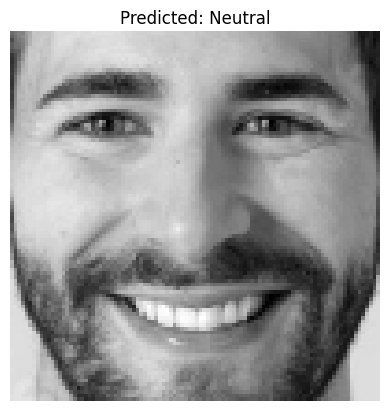

[1]


In [16]:
# Load and preprocess images
img1 = '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/Happy Face - 1.jpg'
images1, encodings1 = load_process_image(img1)

# Predictions
y_pred1 = loaded_model.predict(encodings1)

# Display predictions
for i, face in enumerate(images1):
    plt.imshow(face, cmap='gray')
    pred_label = list(loaded_label_dict.keys())[y_pred[i]]
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

print(y_pred1)

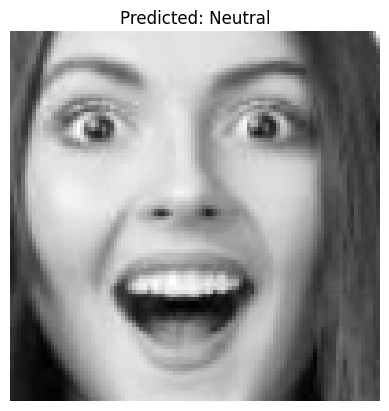

[4]


In [17]:
# Load and preprocess images
img2 = '/content/drive/MyDrive/ML/Supervised - Emotion Analysis/Surprised Face - 1.jpg'
images2, encodings2 = load_process_image(img2)

# Predictions
y_pred2 = loaded_model.predict(encodings2)

# Display predictions
for i, face in enumerate(images2):
    plt.imshow(face, cmap='gray')
    pred_label = list(loaded_label_dict.keys())[y_pred[i]]
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

print(y_pred2)